# Dimension Reduction and unsupervised learning



<div style="background-color:#FFCCCB">

**Recommend reading** for extra information on dimension analysis: https://web.stanford.edu/class/cs246/slides/06-dim_red.pdf and Hands on Machine Learning

<hr style="border:2px solid gray">

## Index: <a id='index'></a>
1. [Dimension Reduction](#DR)
1. [Principal Component Analysis](#PCA)
1. [SVD](#SVD)
1. [Projecting down to d-Dimensions](#PDD)
1. [Looking at MNIST](#MNIST)
1. [Variance Ratio](#VR)
1. [How many dimensions](#DC)
1. [Exercise 1](#Exercise)
1. [Other sorts of PCA](#oPCA)
1. [Unsupervised learning](#UL)
1. [K-Means](#KM)
1. [Exercise 2](#Exercise_2)
1. [Density-Based Spatial Clustering of Applications with Noise](#DBSCAN)



# Dimensionality Reduction [^](#index)
<a id='DR'></a>

We have only examined datasets containing a relatively limited number of features, with **MNIST** being the largest, consisting of 784 features. However, it's common to encounter datasets with thousands or even millions of features. As you have observed, models trained on datasets with numerous features are significantly slower compared to those built on datasets with only a few features - consider the contrast between the iris data and the **MNIST** data. Consequently, when dealing with datasets containing a large number of features, the computational speed can become considerably slower.

There are further reasons to use dimensionality reduction. Even if you transform all your data (so that each feature has a value range between 0 and 1), adding features will add more dimensions to the hyperspace that you need to fill and characterise/model. If you pick two points at random from a unit square (i.e. a two-featured space), their separation is, on average, approximately 0.52; if you go to a 3D cube, then it grows to approximately 0.66. For a million features, i.e. a 1,000,000D hypercube, this has grown to approximately 408.25. This means that your model is now training on very sparse data which may not be representative. The obvious answer is to use more data to train the model; however, you would need more data than there are atoms in the observable universe to have an average separation of 0.1 for just 100 dimensions (not sure how they calculated the actual number of atoms in the observable universe). This is sometimes called [*the curse of dimensionality*](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

So some form of dimensionality reduction can often be very helpful. However, in any such reduction you will loose some information and you want to minimise this. **A good way to consider this is to try to retain the maximum variance in your reduced data set. That way you will (generally) loose the smallest amount of discrimination.**


## Principal Component Analysis (PCA) [^](#index)
<a id='PCA'></a>

While there are many different forms of dimensionality reduction, PCA is by far the most common and so it is the only one that we will really cover, in PCA your data are projected along axes that retain the **greatest variance**.

Consider the diagrams below - don't worry about code that generates them, this is taken directly from {homl}

In [1]:
# first some basics
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


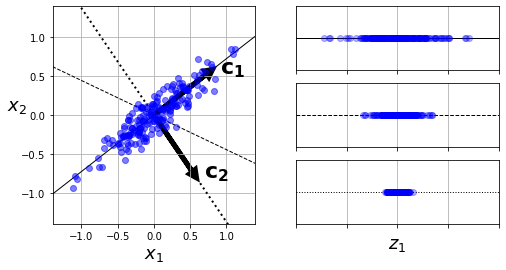

In [2]:
# Define constants for rotation and stretch
angle = np.pi / 5
stretch = 5
m = 200

# Set seed for reproducibility of random data
np.random.seed(3)

# Generate random 2D data and scale it down
X = np.random.randn(m, 2) / 10

# Stretch the data in the direction of the x-axis
X = X.dot(np.array([[stretch, 0],[0, 1]]))

# Rotate the data by the defined angle
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

# Define three unit vectors for projection in different directions
u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

# Project the data onto these three vectors
X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))


plt.figure(figsize=(8,4))

# First subplot: original 2D data with the unit vectors
plt.subplot2grid((3,2), (0, 0), rowspan=3)
# Plot unit vectors and their respective lines
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)


plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])

# Plot arrows representing unit vectors
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')


plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)


plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)

plt.grid(True)

# Second, third, and fourth subplots: projections onto each unit vector
for idx, X_proj in enumerate([X_proj1, X_proj2, X_proj3], start=1):
    plt.subplot2grid((3,2), (idx-1, 1))
    plt.plot([-2, 2], [0, 0], "k-" if idx==1 else "k--" if idx==2 else "k:", linewidth=1)
    plt.plot(X_proj[:, 0], np.zeros(m), "bo", alpha=0.3)
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().get_xaxis().set_ticklabels([])
    plt.axis([-2, 2, -1, 1])
    plt.grid(True)

# Add x-axis label to the last subplot
plt.xlabel("$z_1$", fontsize=18)

plt.show()


This shows the projection of the data along the axes shown. When taking the PCA the first component is the one with the greatest variance -- in this case **C1**. The second principal component is the one with the greatest remaining variance which is **C2**. **C2** is perpendicular to **C1**. If we had more dimensions then we could define more vectors.

To find these vectors, we will use a well known linear algebra technique which factorises matrices - *Single Valued Decomposition* (SVD). 

Numpy has a function which will return these (although the input must be centered around zero)

<div style="background-color:#FFCCCB">

#### [**SVD**](https://www.cs.cmu.edu/~venkatg/teaching/CStheory-infoage/book-chapter-4.pdf) [^](#index)
<a id='SVD'></a>

The singular value decomposition of a matrix $A$ is the factorisation of $M$ into the
product of three matrices $A = UDV^T$ where the columns of $U$ and $V$ are orthonormal and the matrix $D$ is diagonal with positive real entries.

To gain insight into the *SVD*, treat the rows of an n × d matrix A as n points in a
d-dimensional space and consider the problem of finding the best k-dimensional subspace with respect to the set of points. Here best means minimize the sum of the squares of the perpendicular distances of the points to the subspace. We begin with a special case of the problem where the subspace is 1-dimensional, a line through the origin. We will see later that the best-fitting k-dimensional subspace can be found by k applications of the best fitting line algorithm. Finding the best fitting line through the origin with respect to a set of points ${\{x_i|1 ≤ i ≤ n\}}$ in the plane means minimizing the sum of the squared distances of the points to the line. Here distance is measured perpendicular to the line. The problem is called the best least squares fit.

In [3]:
X_centered = X-X.mean(axis=0)

U,s, Vh=np.linalg.svd(X_centered) # docs at https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
c1=Vh.T[:,0]
c2=Vh.T[:,1]

## Projecting Down to d - Dimensions [^](#index)
<a id='PDD'></a>

After identifying the principal components, you can project the data onto a hyperplane of dimension 'd' that's defined by the initial 'd' principal components. This process is designed to minimize the loss of data variance.

## Looking at **MNIST** (again) [^](#index)
<a id='MNIST'></a>

So let's return to our old friend MNIST

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())

In [ ]:
X=mnist['data']
y=mnist['target']

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Hint**: Using PCA is even easier in sklearn than it is in numpy as it does all the zeroing for you

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=200) # choose the first 200 components out 784
X_reduced=pca.fit_transform(X_train)

In [ ]:
# the components will then just be stored in pca.components.T i.e. the transpose
print(len(pca.components_)) # should be 200 vectors
print(len(pca.components_.T[:,0])) # in 784 dimensions
print(len(X_reduced)) #should be 60000 from all the original training data
print(len(X_reduced[0,:])) # should now only be 200 not 784

## Explained Variance Ratio [^](#index)
<a id='VR'></a>

The explained variance ratio indicates the proportion of the dataset's variance that lies along each principal component, so we can see the speed at which the variance drops off. For example, using just the first 10 components in MNIST leads to a variance loss of around 3% (not much).

In [ ]:
print(pca.explained_variance_ratio_[0:10])
print("lost=",1-pca.explained_variance_ratio_.sum())

## How many dimensions to choose? [^](#index)
<a id='DC'></a>

Rather than plucking a number out of a hat, you could decide how much variance you wish to retain and use this to decide the dimensionality that you want to use. You could do this for an increasing number of dimensions and then see which is the first above your threshold.


In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

Sklearn can also do this for you. Rather than $n_{components}$ being equal to a number of principal components, n_components can instead be the variance ratio that you want to keep (a number between 0 and 1). 

In [ ]:
pca=PCA(n_components=0.95)
X_reduced=pca.fit_transform(X_train)
pca.n_components_

You could also plot the explained variance as a function of the number of dimensions.

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

The value of 154 means that you only need to store $\approx$ 20% of the data for 95% of the information so you can use this as a form of compression. Look at the example below and note how you can reverse the transformation but that you have lost some information.

In [ ]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
pca = PCA(n_components = 154) 
#try varying n_components (starting at 1) and see what difference it makes to the images
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


<div style="background-color:#C2F5DD">

## Exercise [^](#index)
<a id='Exercise'></a>

As the comment suggests, try varying the number of dimensions and seeing what difference it makes to the the image. Start with very low numbers and build up.

<div style="background-color:#C2F5DD">

## Exercise

Use your favourite classifier (e.g. SVC or BDT) to classify the MNIST data set as well as you can. Then see how the timing and accuracy changes if you use versions with reduced dimensions and plot your reults (say accuracy against number of dimensions). This is what you are really interested in.

[SVC: Support Vector Classification; BDT: Boosted Decision Trees]

## Other sorts of PCA [^](#index)
<a id='oPCA'></a>

We don't have time here but you should be aware that there are also varioants of PCA that can be useful. These include:
* **Kernel PCA** where you use a similar kernel trick as with SVMs to introduce nonlinear features (without really doing so).
* Randomised **PCA** that generates good approximations to the PC in a semi-random way and is very much faster for large feature sets.


## Other forms of dimensionality reduction

There exist many other forms of dimensionality reduction but none anywhere near as popular as PCA. Thes include: Locally Linear Embedding, Random Projections, Linear Discriminant Analysis, ... They all have their place and you should know that there are more out there that exist.

# Unsupervised learning [Ideally want to reformat sessions] [^](#index)
<a id='UL'></a>


I was rather hoping to spend this entire session on unsupervised learning, but figured that dimensionality reduction was so important that it had to be covered explicitly.

As it is I can only give you a taste of this and show you an example of a commonly used approach (and give you an exercise of course).

Although you should note that dimensionality reduction is in itself a form of unsupervised learning as you only consider the variance of the data and not the targets.

## So what is unsuperived learning and what is it used for?

As you might have guessed, unsupervised learning is where you don't have the answer to what you are looking i.e. you don't have the target, so you cannot train your favourite classifier. Somehow you need an algorithm that will train a model to pick things that are "the same". This could be trying to distinguish coins on weight and diameter without know which coin is which - this is often used as an example. 

The most common form is clustering (although fault detection and density estimation are other common forms) and the most common form of clustering is K-Means, so this is the example that we will look at. Again, this is an example taken from {homl}.

## K-Means [^](#index)
<a id='KM'></a>

K-means can take an unlabeled data set and group it into clusters. So let's generate some random data made up of clusters.

In [6]:
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt

In [7]:
from sklearn.datasets import make_blobs
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])


In [8]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [9]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

[[-2.69823941  1.3454702 ]
 [-2.87459835  1.8097575 ]
 [ 0.96077126  1.17046777]
 ...
 [-2.80303543  2.72948115]
 [ 0.24057359  2.40103109]
 [-2.63807768  1.95621065]]


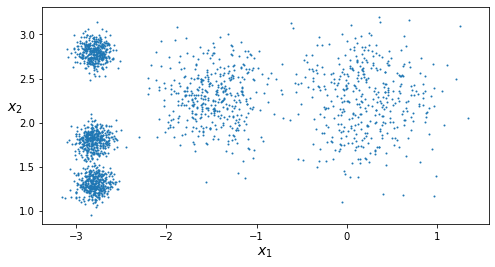

In [10]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
print(X)
plt.show()

We have five new blobs of data, but how can we make a model identify each blob? If we knew the centroids of each blob or the identity of each entry, this task would be easy. However, in unsupervised learning, we have neither of these.

K-Means starts by randomly selecting centroids and classifying each instance based on its nearest centroid. It then updates the centroids using the associated data. This process continues iteratively, with instances being reclassified and centroids recalculated until the centroids no longer move. It's a simple yet effective approach. Let's give it a try here:

In [11]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Unfortunately, you have to tell it how many clusters to look for, but hey, now each of the data points has been assigned to one of the 5 clusters:

In [12]:
print(y_pred[0:20])

[4 0 1 0 0 4 0 0 3 0 0 0 0 4 0 4 2 3 2 1]


In [13]:
kmeans.cluster_centers_ # to find the centres of the clusters

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Let's look at how well it did:

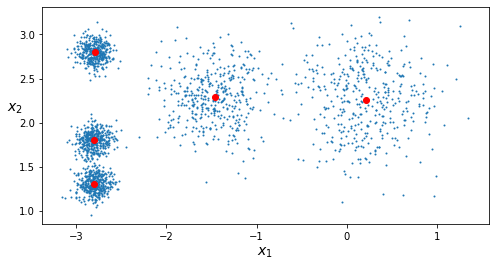

In [14]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
#print(X)
plt.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],"ro")
#print(kmeans.inertia_)
plt.show() # pretty good

You can use it to predict the label for new data

In [15]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]]) #try adding some more to see what happens
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

You can plot the decision boundaries as a Voronoi plot (code taken straight from {homl}):

In [16]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)  # Plotting data points from input X

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]  # Filter centroids based on their weights
    plt.scatter(centroids[:, 0], centroids[:, 1],  # Plot centroids
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],  # Plot centroids
                marker='x', s=10, linewidths=10,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1 
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),  # Generate grid of points in the defined limits
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])  # Perform clustering on the grid points
    Z = Z.reshape(xx.shape)  # Reshape results to have same shape as the grid

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),  # Plot the filled contours (decision boundaries)
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),  # Plot the contour lines
                linewidths=1, colors='k')
    plot_data(X)  # Plot the original data
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)  # Plot the centroids if specified

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)  # Show x-axis label if specified
    else:
        plt.tick_params(labelbottom=False)  # Hide x-axis labels
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)  # Show y-axis label if specified
    else:
        plt.tick_params(labelleft=False)  # Hide y-axis labels


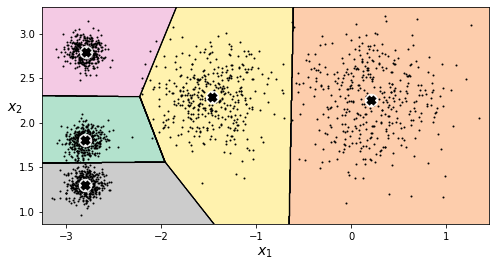

In [17]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

If you happen to have a vague idea of where the centroids are, you can tell it where to start:
```python
init_guess=np.array([-3,1.0],[-3,2],[-3,3],[-1,2],[0,2])
kmeans=KMeans(n-cluster=5,init=init_guess,n_inits=5)
```

### Inertia

When the K-Means algorithm runs, it actually runs several times. The number of times it runs is given by n_inits and the default value is 10. It then uses a performance algorithm to detemine which is the best and keeps that one. The performance metric is called *inertia* and is the mean squared distance between each centroid and the instances associated with it. This is available to you.

In [ ]:
kmeans.inertia_

<div style="background-color:#C2F5DD">

## Exercise 2 [^](#index)
<a id='Exercise_2'></a>

Plot what happens to the inertia score as you change the number of centroids in your algorithm. Can you use this to determine how many centroids you should have?

<div style="background-color:#C2F5DD">

## Exercise

Try to use K-Means on the iris data to separate them out without using labels. Even though we have only been using 2D to show plots the algorithm will happily run in multiple dimensions.


In [ ]:
import numpy as np
import scipy as sp 
from sklearn.datasets import load_iris
iris=load_iris()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size=0.2) 
k = 4
kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
y_pred = kmeans.fit_predict(X_train)

In [ ]:
yp=kmeans.predict(X_test)

In [ ]:
print(yp)

In [ ]:
print(y_test)

In [ ]:
#How accurate was this? Can you write code to classify the accuracy?


### Density-based spatial clustering of applications with noise (DBSCAN) [^](#index)
<a id='DBSCAN'></a>

DBSCAN is a popular clustering algorithm used in machine learning and data mining. Unlike K-Means, which requires specifying the number of clusters in advance, DBSCAN automatically determines the number of clusters based on the density of the data.

DBSCAN operates by grouping together data points that are close to each other in a dense region, while separating regions of lower density. It identifies core points, which have a sufficient number of neighboring points within a specified distance (epsilon), and expands clusters by including reachable points within this distance. Any points that are not part of a cluster are considered outliers or noise.

Practical usage: In high-energy physics experiments, particle tracks are reconstructed from the signals recorded by particle detectors. DBSCAN can be applied to identify and group together the recorded signals that belong to the same particle track. By clustering these signals based on their spatial proximity, DBSCAN helps in reconstructing the paths of particles accurately.


<div style="background-color:#C2F5DD">

## Optional Exercise


We have a dataset of particles with two features: momentum and charge. The goal is to group these particles based on these two features.

Let's first simulate this data:

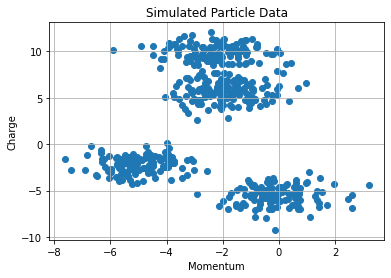

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

np.random.seed(50)

# Make up data for 4 different particles
data, _ = make_blobs(n_samples=500, centers=4, cluster_std=1)

# Let's say the first feature is momentum and the second is charge
momentum = data[:, 0]
charge = data[:, 1]

plt.scatter(momentum, charge)
plt.xlabel('Momentum')
plt.ylabel('Charge')
plt.title('Simulated Particle Data')
plt.grid(True)
plt.show()


Here, we are simulating data from four types of particles, each with different distributions of momentum and charge.

Next, let's use DBSCAN to identify the particle types:

DBSCAN takes two parameters, the **eps** which specifies the maximum distance between two samples for them to be considered as in the same neighborhood, and **min_sample**s which is the number of samples in a neighborhood for a point to be considered as a core point. You can alter these parameters based on the density of your data points.


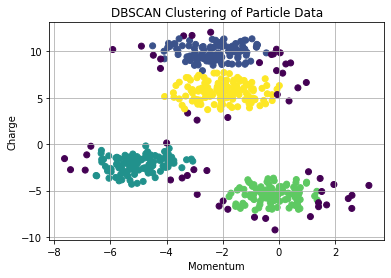

In [2]:
# Perform DBSCAN on data
dbscan = DBSCAN(eps=0.7, min_samples=10)
clusters = dbscan.fit_predict(data)

# Plot the clustered data
plt.scatter(momentum, charge, c=clusters, cmap='viridis')
plt.xlabel('Momentum')
plt.ylabel('Charge')
plt.title('DBSCAN Clustering of Particle Data')
plt.grid(True)
plt.show()


Try to alter the values in DBSCAN to see how the plot changes